In [1]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [39]:
meta = unpickle('./data/CIFAR-10/meta')
trainset = unpickle('./data/CIFAR-10/train')
testset = unpickle('./data/CIFAR-10/test')

In [131]:
fine_label_names = meta[b'fine_label_names']
coarse_label_names = meta[b'coarse_label_names']

filenames = trainset[b'filenames']
batch_label = trainset[b'batch_label']
fine_labels = trainset[b'fine_labels']
coarse_labels = trainset[b'coarse_labels']
data = trainset[b'data']

In [111]:
for i in range(3):
    print(filenames[i])
    print(batch_label[i])
    print(fine_label_names[fine_labels[i]])
    print(coarse_label_names[coarse_labels[i]])
    print()

b'bos_taurus_s_000507.png'
116
b'cattle'
b'large_omnivores_and_herbivores'

b'stegosaurus_s_000125.png'
114
b'dinosaur'
b'reptiles'

b'mcintosh_s_000643.png'
97
b'apple'
b'fruit_and_vegetables'



In [112]:
examples = []
for i in range(len(filenames)):
    # Reshape the image data to 32x32x3
    image = data[i].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8)
    
    # Create an example with the image, fine label, and coarse label
    example = {
        'image': image,
        'fine_label': fine_label_names[fine_labels[i]],
        'coarse_label': coarse_label_names[coarse_labels[i]]
    }
    
    # Append the example to the list
    examples.append(example)

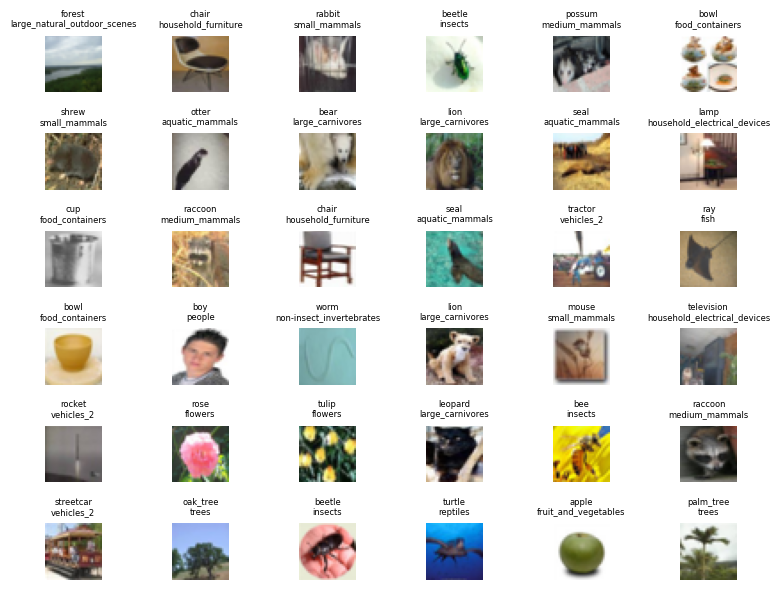

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Assuming 'data', 'fine_label_names', and 'fine_labels' are defined from previous context

# Set up the grid size
grid_size = 6

# Create a figure and a grid of subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 6))

# Randomly select 25 images
indices = random.sample(range(len(filenames)), grid_size * grid_size)

for ax, idx in zip(axes.flatten(), indices):
    # Reshape and transpose the image data
    image = data[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8)
    
    # Display the image
    ax.imshow(image)
    
    fine_label = fine_label_names[fine_labels[idx]].decode('utf-8')
    coarse_label = coarse_label_names[coarse_labels[idx]].decode('utf-8')
    
    ax.set_title(f"{fine_label}\n{coarse_label}", fontsize=6)
    
    # Remove axis ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the grid
plt.show()

In [141]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import numpy as np

# Custom dataset class to handle your examples
class ImageDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        image = np.array(self.examples[idx]['image']).astype(np.float32) / 255.0
        image = torch.from_numpy(image).reshape(-1)  # Flatten the image to a 1D tensor of shape [3072]
        return image, idx

# Define the AutoEncoder class
class AutoEncoder(nn.Module):
    def __init__(self, input_dims, latent_dims):
        super().__init__()

        self.latent_dims = latent_dims

        self.encoder = nn.Sequential(
            nn.Linear(input_dims, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dims)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, input_dims)
        )

    def forward(self, x):
        encoding = self.encoder(x)
        decoding = self.decoder(encoding)
        return decoding

In [142]:
# Prepare the dataset and dataloader
dataset = ImageDataset(examples)
batch_size = 1000
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

models = []

for dim in [256]:
    print(f'Training model with {dim} latent dimensions')
    
    # Example image for size reference
    image = np.array(examples[0]['image'])
    model = AutoEncoder(image.size, dim)
    # model.to(mps_device)  # Uncomment if using MPS or GPU
    
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999))
    
    model.train()

    for epoch in range(200):
        # print(f'Epoch {epoch + 1}')
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(model.parameters().__next__().device)
            
            pred = model(x)
            loss = loss_fn(pred, x)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        print(f'Loss after epoch {epoch + 1}: {loss.item()}')
    
    models.append(model)

Training model with 256 latent dimensions
Loss after epoch 1: 0.053475819528102875
Loss after epoch 2: 0.04855496808886528
Loss after epoch 3: 0.048209503293037415
Loss after epoch 4: 0.04888111725449562
Loss after epoch 5: 0.04921399801969528
Loss after epoch 6: 0.04214565083384514
Loss after epoch 7: 0.04033486545085907
Loss after epoch 8: 0.040796637535095215
Loss after epoch 9: 0.037054356187582016
Loss after epoch 10: 0.037091709673404694
Loss after epoch 11: 0.035964857786893845
Loss after epoch 12: 0.03577181324362755
Loss after epoch 13: 0.03561059385538101
Loss after epoch 14: 0.035205043852329254
Loss after epoch 15: 0.03208693116903305
Loss after epoch 16: 0.031099827960133553
Loss after epoch 17: 0.03201554715633392
Loss after epoch 18: 0.03194763883948326
Loss after epoch 19: 0.030562447383999825
Loss after epoch 20: 0.030923431739211082
Loss after epoch 21: 0.03119528666138649
Loss after epoch 22: 0.030961431562900543
Loss after epoch 23: 0.03070848062634468
Loss after ep

ValueError: 'c' argument has 60000 elements, which is inconsistent with 'x' and 'y' with size 5000.

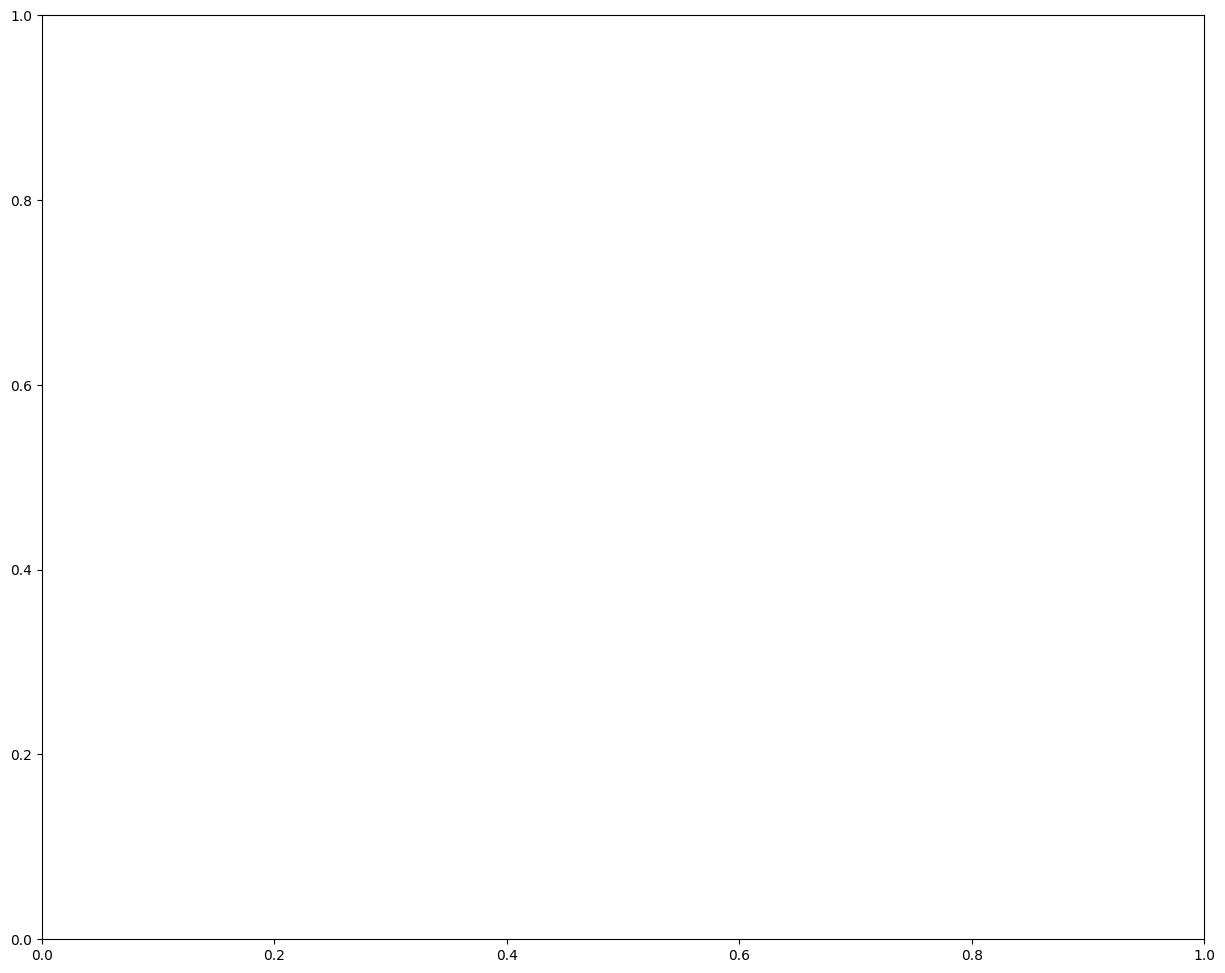

In [138]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

# Assume 'model' is the trained AutoEncoder model and 'dataset' is the ImageDataset instance
model = models[0]

# Set the model to evaluation mode
model.eval()

# Sample 5000 random examples
num_samples = 5000
indices = random.sample(range(len(dataset)), num_samples)

# Prepare arrays to store the encoded representations and labels
encoded_samples = []
c_labels = []

# Encode the sampled examples
with torch.no_grad():
    for idx in indices:
        image, _ = dataset[idx]
        image = image.unsqueeze(0)  # Add batch dimension
        encoded = model.encoder(image).squeeze(0).numpy()  # Encode and remove batch dimension
        encoded_samples.append(encoded)
        coarse_labels.append(examples[idx]['coarse_label'])  # Assuming you have access to the coarse labels

# Convert to numpy arrays
encoded_samples = np.array(encoded_samples)
c_labels = np.array(coarse_labels)

# Map coarse labels to numeric values
label_encoder = LabelEncoder()
coarse_labels_numeric = label_encoder.fit_transform(c_labels)

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(encoded_samples)

# Create a color map and labels
cmap = plt.get_cmap('tab20')  # Use 'tab20' for up to 20 categories
colors = [cmap(i) for i in range(len(label_encoder.classes_))]
labels = label_encoder.classes_

# Plot the t-SNE results
plt.figure(figsize=(15, 12))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=coarse_labels_numeric, cmap='tab20', s=10, alpha=0.6)

# Create legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10, label=label) for i, label in enumerate(labels)]
plt.legend(handles=handles, title='Coarse Labels', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.clim(-0.5, len(label_encoder.classes_) - 0.5)
plt.title('t-SNE of Encoded Images with Coarse Labels')

plt.show()

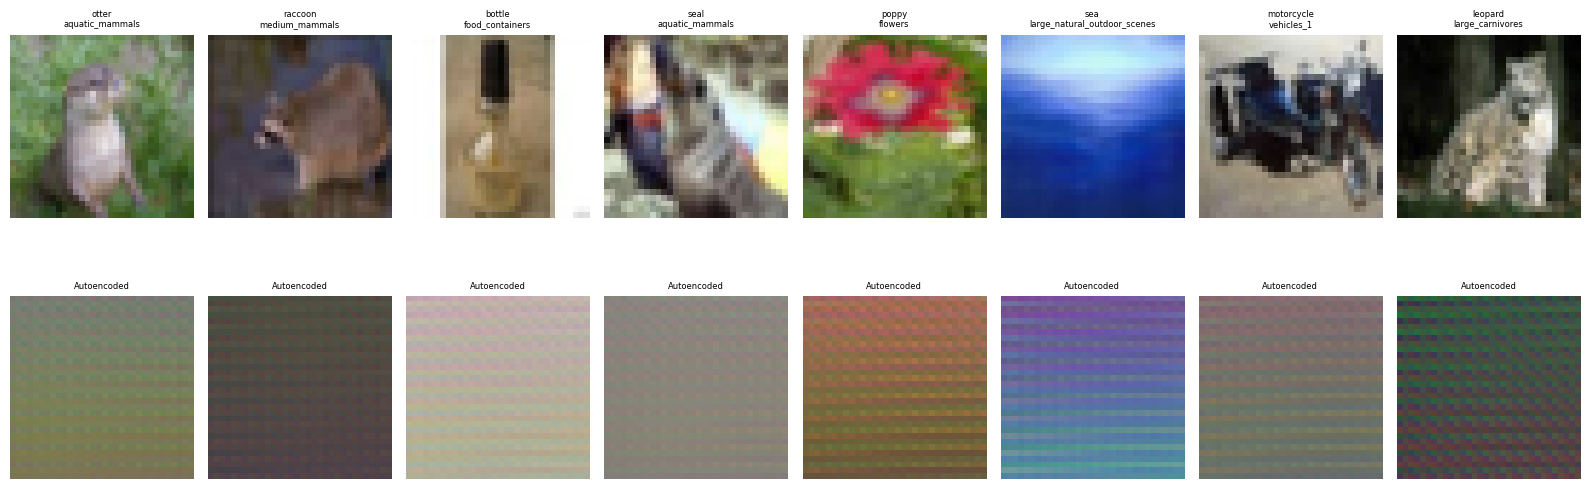

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch

# Set up the number of images per row
num_images = 8

# Create a figure and a grid of subplots
fig, axes = plt.subplots(2, num_images, figsize=(16, 6))  # 2 rows, num_images columns

# Randomly select images
indices = random.sample(range(len(data)), num_images)

# Set the model to evaluation mode
model.eval()

# Encode and decode function
def encode_decode(image):
    with torch.no_grad():
        image_tensor = torch.from_numpy(image).float().unsqueeze(0)
        encoded = model.encoder(image_tensor).cpu().numpy().flatten()
        decoded = model.decoder(torch.from_numpy(encoded).float().unsqueeze(0)).cpu().numpy()
        decoded_image = decoded.reshape(3, 32, 32).transpose(1, 2, 0) * 255.0
        decoded_image = np.clip(decoded_image, 0, 255).astype(np.uint8)
        return decoded_image

# Plot original and autoencoded images
for col, idx in enumerate(indices):
    # Original image
    image = data[idx].reshape(3, 32, 32).transpose(1, 2, 0).astype(np.uint8)
    axes[0, col].imshow(image)
    fine_label = fine_label_names[fine_labels[idx]].decode('utf-8')
    coarse_label = coarse_label_names[coarse_labels[idx]].decode('utf-8')
    axes[0, col].set_title(f"{fine_label}\n{coarse_label}", fontsize=6)
    axes[0, col].axis('off')
    
    # Autoencoded/decoded image
    decoded_image = encode_decode(data[idx].astype(np.float32) / 255.0)
    axes[1, col].imshow(decoded_image)
    axes[1, col].set_title("Autoencoded", fontsize=6)
    axes[1, col].axis('off')

# Adjust spacing between subplots
plt.tight_layout()

# Display the grid
plt.show()